In [1]:
from google.colab import drive 
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [2]:
!unzip /content/gdrive/MyDrive/Dacon/airline/airline_dataset.zip

Archive:  /content/gdrive/MyDrive/Dacon/airline/airline_dataset.zip
  inflating: sample_submission.csv   
  inflating: test.csv                
  inflating: train.csv               


In [4]:
!pip install catboost

     |████████████████████████████████| 76.1 MB 1.2 MB/s 


In [5]:
import warnings
warnings.filterwarnings(action='ignore')

import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)
from pandas.api.types import is_numeric_dtype, is_categorical_dtype

import matplotlib.pyplot as plt
import seaborn as sns

import os
import sys
import random

from sklearn import preprocessing
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

from tqdm import tqdm
from catboost import CatBoostClassifier

In [6]:
print('Load data...')
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')

df_train = df_train.drop('id', axis=1)
df_test = df_test.drop('id', axis=1)

print('The shape of train:', df_train.shape)
print('The shape of test :', df_test.shape)

Load data...
The shape of train: (3000, 23)
The shape of test : (2000, 22)


In [7]:
df_train.head(2)

,Gender,Customer Type,Age,Type of Travel,Class,Flight Distance,Seat comfort,Departure/Arrival time convenient,Food and drink,Gate location,Inflight wifi service,Inflight entertainment,Online support,Ease of Online booking,On-board service,Leg room service,Baggage handling,Checkin service,Cleanliness,Online boarding,Departure Delay in Minutes,Arrival Delay in Minutes,target
0,Female,disloyal Customer,22,Business travel,Eco,1599,3,0,3,3,4,3,4,4,5,4,4,4,5,4,0,0.0,0
1,Female,Loyal Customer,37,Business travel,Business,2810,2,4,4,4,1,4,3,5,5,4,2,1,5,2,18,18.0,0


In [8]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 23 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   Gender                             3000 non-null   object 
 1   Customer Type                      3000 non-null   object 
 2   Age                                3000 non-null   int64  
 3   Type of Travel                     3000 non-null   object 
 4   Class                              3000 non-null   object 
 5   Flight Distance                    3000 non-null   int64  
 6   Seat comfort                       3000 non-null   int64  
 7   Departure/Arrival time convenient  3000 non-null   int64  
 8   Food and drink                     3000 non-null   int64  
 9   Gate location                      3000 non-null   int64  
 10  Inflight wifi service              3000 non-null   int64  
 11  Inflight entertainment             3000 non-null   int64

In [9]:
print('The number of unique values')
for col in df_train.columns:
    print(f'\t{col}: {df_train[col].nunique()}')

The number of unique values
	Gender: 2
	Customer Type: 2
	Age: 72
	Type of Travel: 2
	Class: 3
	Flight Distance: 2012
	Seat comfort: 6
	Departure/Arrival time convenient: 6
	Food and drink: 6
	Gate location: 5
	Inflight wifi service: 6
	Inflight entertainment: 6
	Online support: 5
	Ease of Online booking: 6
	On-board service: 5
	Leg room service: 6
	Baggage handling: 5
	Checkin service: 5
	Cleanliness: 5
	Online boarding: 6
	Departure Delay in Minutes: 169
	Arrival Delay in Minutes: 176
	target: 2


n_unique < 10 이면 categorical feature로 간주

In [10]:
cat_features = [] # categorical features
num_features = [] # numeric features

for f in df_train.columns:
    if df_train[f].nunique() < 10:
        cat_features.append(f)
        #df_train[f] = df_train[f].astype(np.object)
    else:
        num_features.append(f)


print(f'Categorical Features: size: {len(cat_features)}, {cat_features}')
print(f'Numeric Features: size: {len(num_features)}, {num_features}')

Categorical Features: size: 19, ['Gender', 'Customer Type', 'Type of Travel', 'Class', 'Seat comfort', 'Departure/Arrival time convenient', 'Food and drink', 'Gate location', 'Inflight wifi service', 'Inflight entertainment', 'Online support', 'Ease of Online booking', 'On-board service', 'Leg room service', 'Baggage handling', 'Checkin service', 'Cleanliness', 'Online boarding', 'target']
Numeric Features: size: 4, ['Age', 'Flight Distance', 'Departure Delay in Minutes', 'Arrival Delay in Minutes']


# EDA - Categorical Features

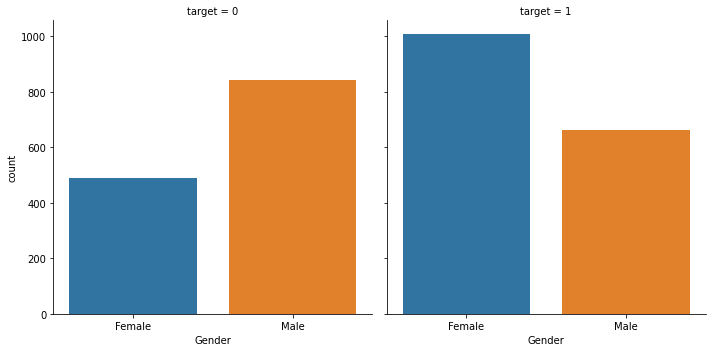

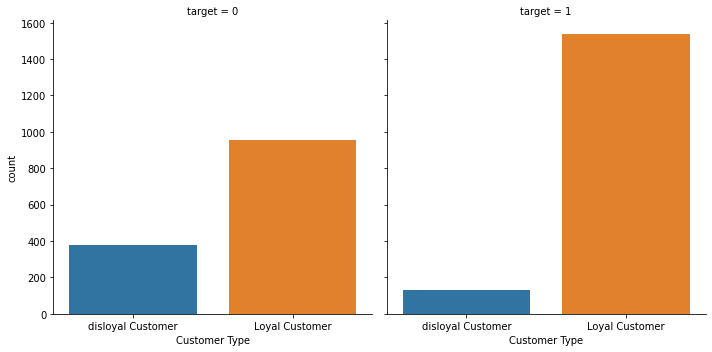

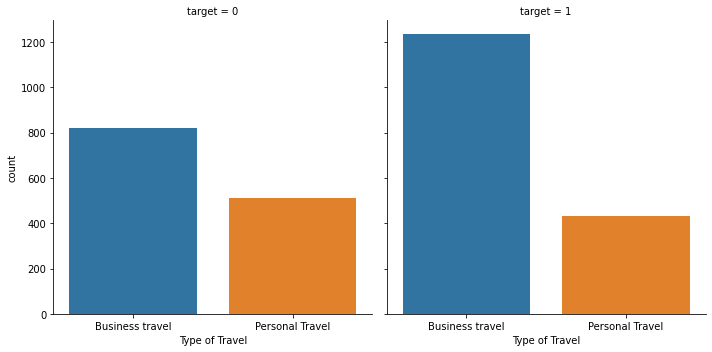

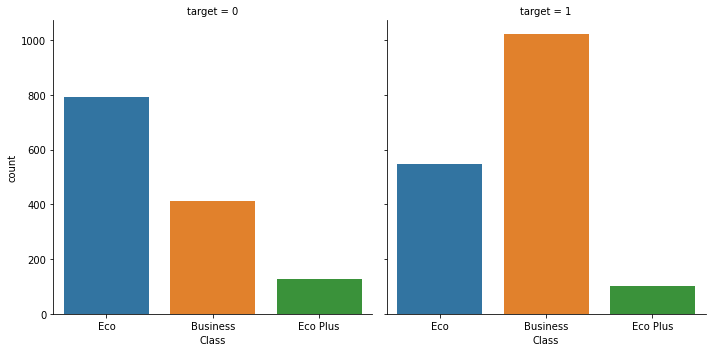

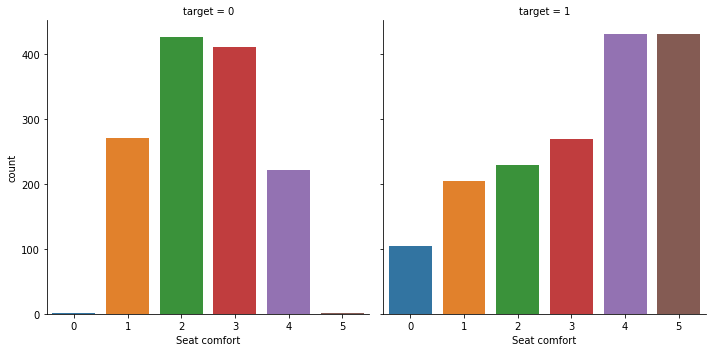

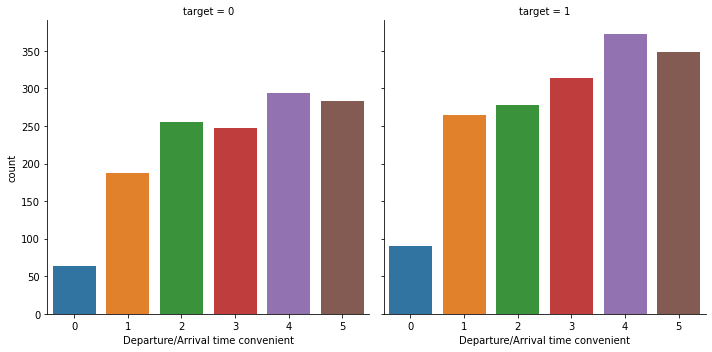

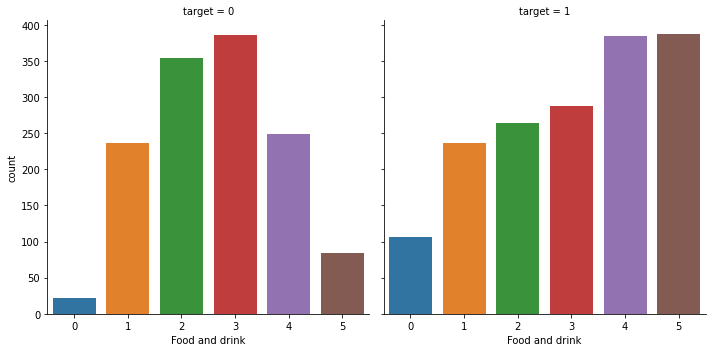

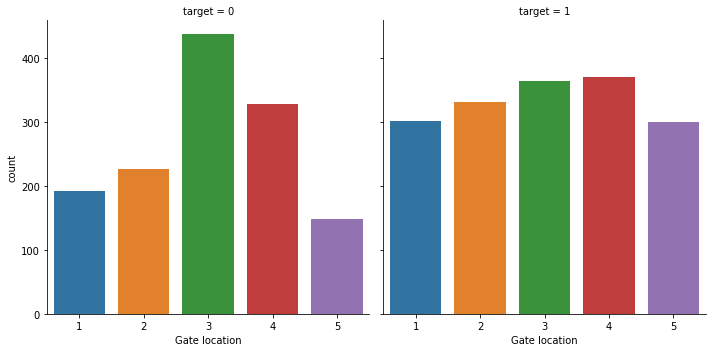

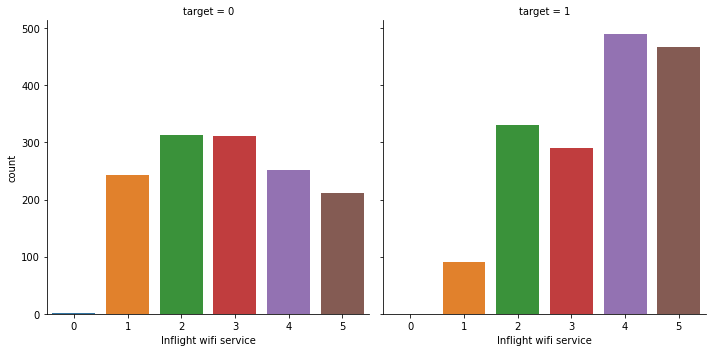

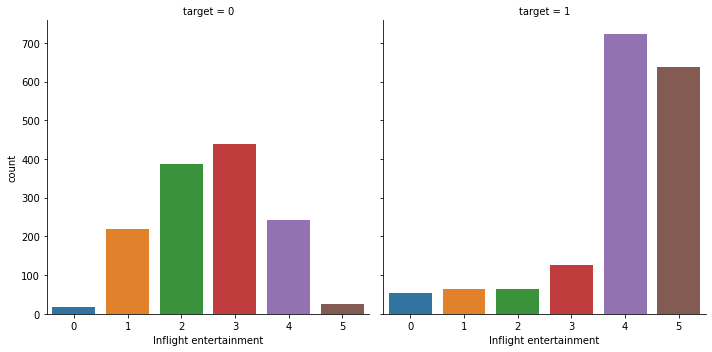

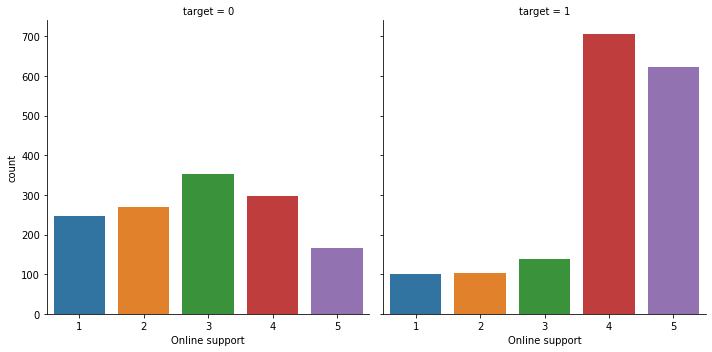

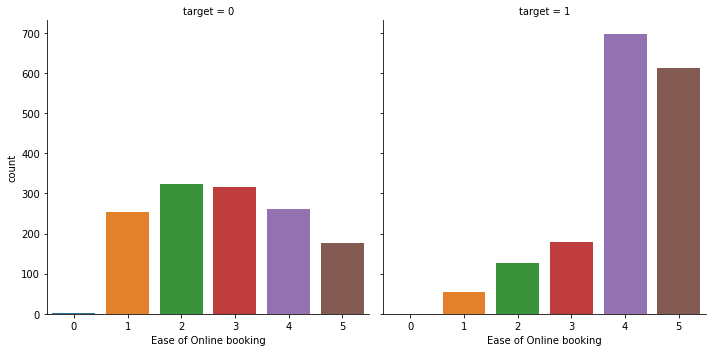

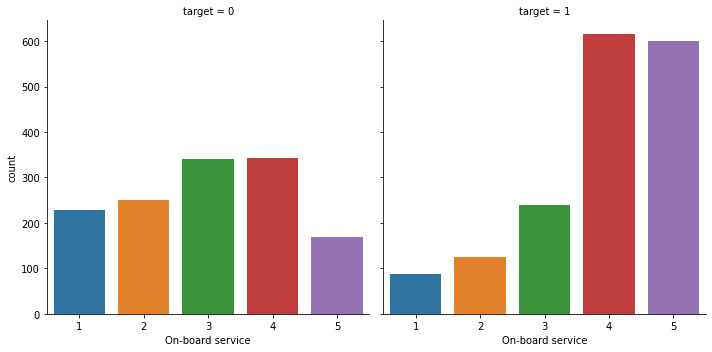

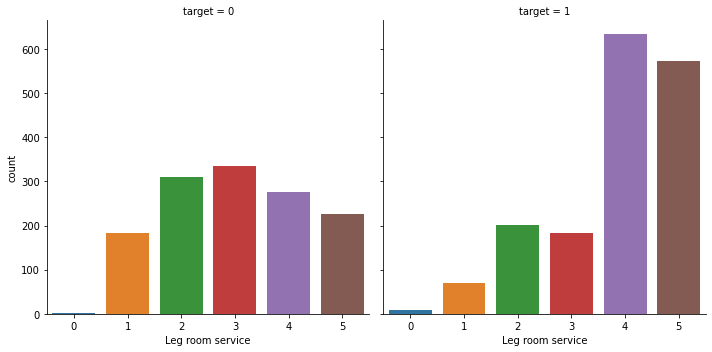

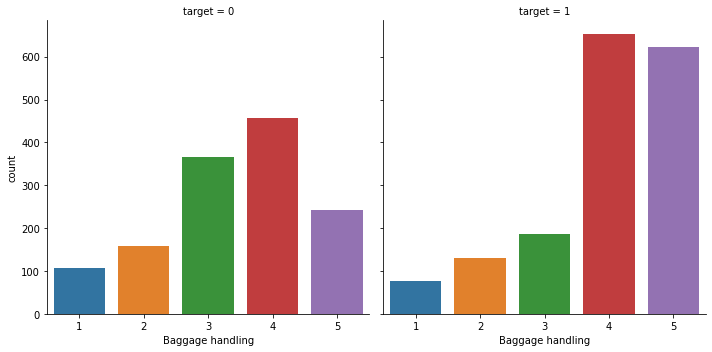

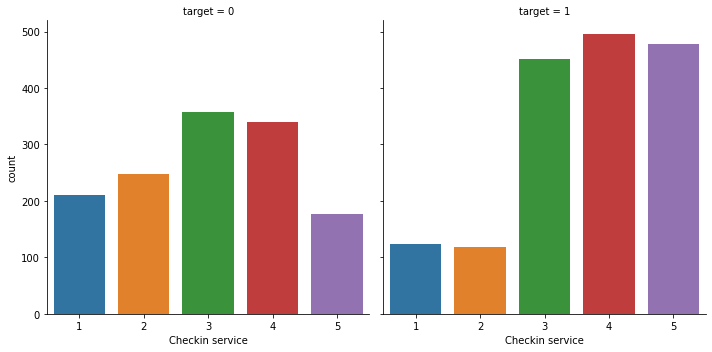

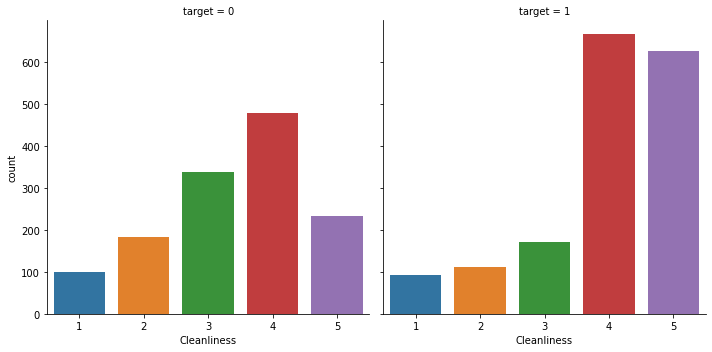

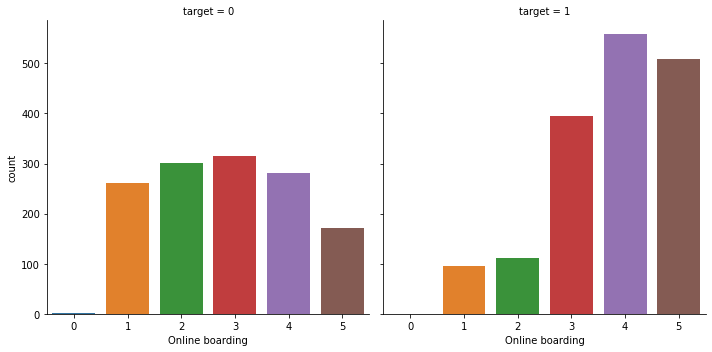

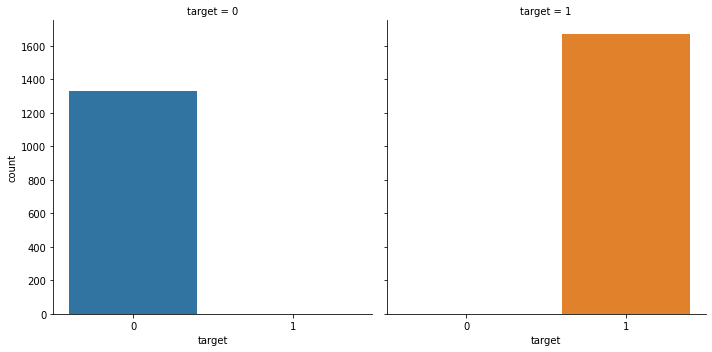

In [11]:
for f in cat_features:
    sns.catplot(data=df_train, col='target', x=f, kind='count')
    plt.show()

## target 비율 보기

In [12]:
for f in cat_features:
    print(df_train['target'].groupby(df_train[f]).mean().sort_index())
    print()

Gender
Female    0.67223
Male      0.44008
Name: target, dtype: float64

Customer Type
Loyal Customer       0.617115
disloyal Customer    0.258317
Name: target, dtype: float64

Type of Travel
Business travel    0.601072
Personal Travel    0.458289
Name: target, dtype: float64

Class
Business    0.711994
Eco         0.408377
Eco Plus    0.441048
Name: target, dtype: float64

Seat comfort
0    0.990566
1    0.430672
2    0.349618
3    0.395588
4    0.660522
5    0.995370
Name: target, dtype: float64

Departure/Arrival time convenient
0    0.584416
1    0.584989
2    0.521576
3    0.558719
4    0.558559
5    0.552215
Name: target, dtype: float64

Food and drink
0    0.829457
1    0.500000
2    0.427184
3    0.427300
4    0.607256
5    0.821656
Name: target, dtype: float64

Gate location
1    0.611336
2    0.594982
3    0.454432
4    0.530086
5    0.668151
Name: target, dtype: float64

Inflight wifi service
0    0.000000
1    0.272455
2    0.513219
3    0.482587
4    0.660811
5    0.688791

# 분포가 비슷하면 중요하지 않은 feature로 간주

In [13]:
remove_cat_features = ['Departure/Arrival time convenient', 'target']
selected_cat_features = []
for f in cat_features:
    if f not in remove_cat_features:
        selected_cat_features.append(f)
print(len(selected_cat_features), selected_cat_features)

17 ['Gender', 'Customer Type', 'Type of Travel', 'Class', 'Seat comfort', 'Food and drink', 'Gate location', 'Inflight wifi service', 'Inflight entertainment', 'Online support', 'Ease of Online booking', 'On-board service', 'Leg room service', 'Baggage handling', 'Checkin service', 'Cleanliness', 'Online boarding']


# EDA - Numerical Features

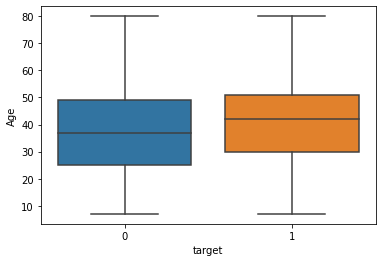

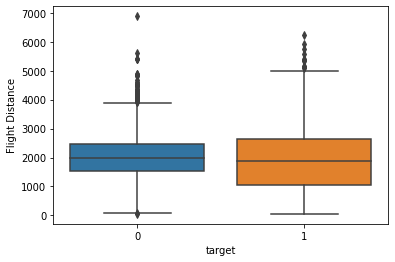

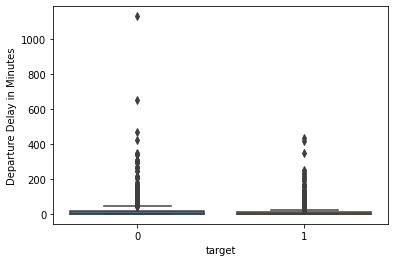

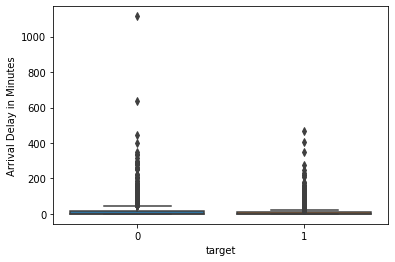

In [16]:
for f in num_features:
    sns.boxplot(data=df_train, y=f, x='target')
    plt.show()

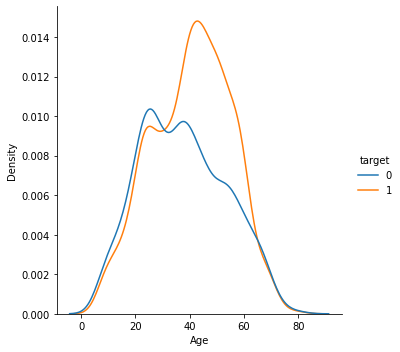

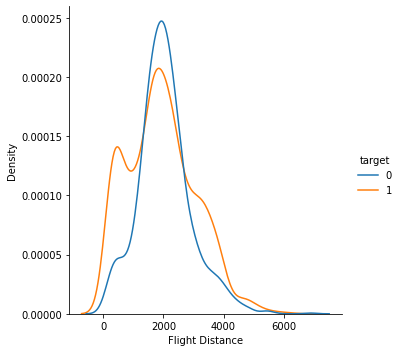

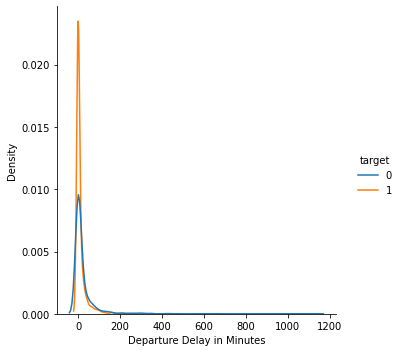

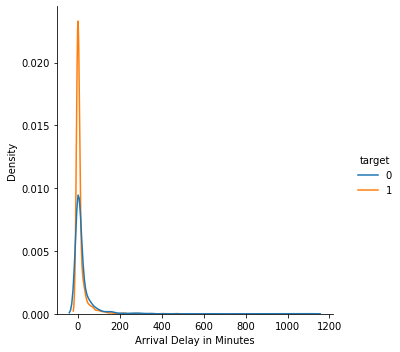

In [15]:
for f in num_features:
    sns.displot(data=df_train, x=f, hue='target', kind='kde')
    plt.show()

# Delay 관련 feature는 skewness가 심함 -> log 변환

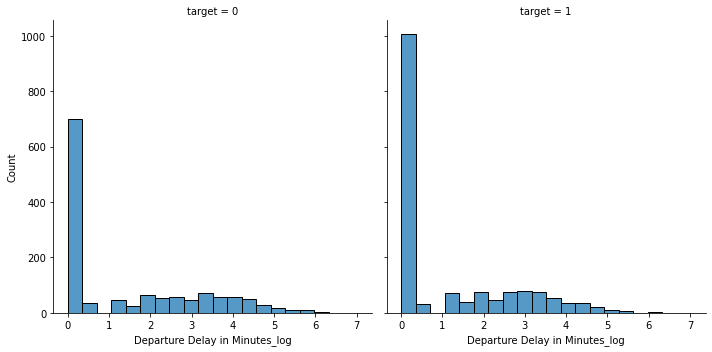

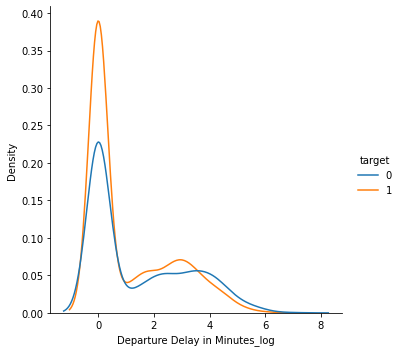

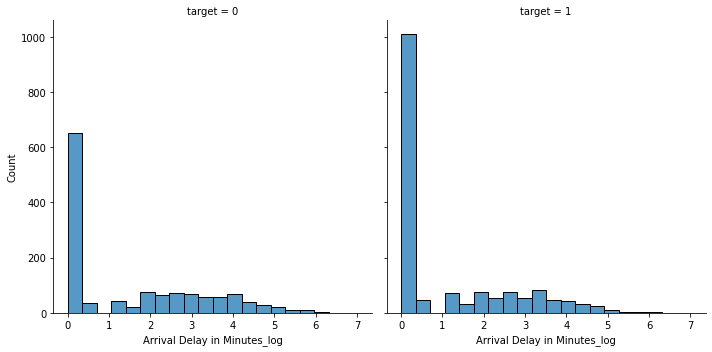

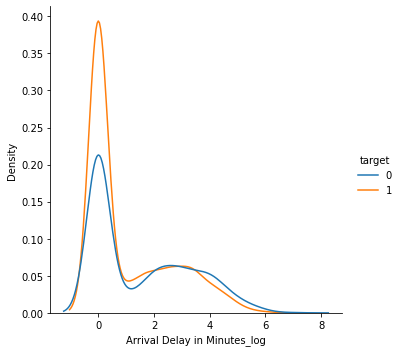

In [17]:
delay_features = ['Departure Delay in Minutes', 'Arrival Delay in Minutes']
for f in delay_features:
    df_train[f'{f}_log'] = np.log1p(df_train[f])

for f in delay_features:
    sns.displot(data=df_train, col='target', x=f'{f}_log')
    plt.show()

    sns.displot(data=df_train, x=f'{f}_log', hue='target', kind='kde')
    plt.show()

In [18]:
remove_num_features = ['Departure Delay in Minutes', 'Arrival Delay in Minutes']
selected_num_features = []
for f in num_features:
    if f not in remove_num_features:
        selected_num_features.append(f)

for f in delay_features:
    selected_num_features.append(f'{f}_log')

print(len(selected_num_features), selected_num_features)

4 ['Age', 'Flight Distance', 'Departure Delay in Minutes_log', 'Arrival Delay in Minutes_log']


In [19]:
selected_features = selected_cat_features + selected_num_features
print(len(selected_features), selected_features)

21 ['Gender', 'Customer Type', 'Type of Travel', 'Class', 'Seat comfort', 'Food and drink', 'Gate location', 'Inflight wifi service', 'Inflight entertainment', 'Online support', 'Ease of Online booking', 'On-board service', 'Leg room service', 'Baggage handling', 'Checkin service', 'Cleanliness', 'Online boarding', 'Age', 'Flight Distance', 'Departure Delay in Minutes_log', 'Arrival Delay in Minutes_log']


In [20]:
rating_features = []
for f in selected_cat_features:
    if df_train[f].nunique() >= 5:
        rating_features.append(f)

print(rating_features)

['Seat comfort', 'Food and drink', 'Gate location', 'Inflight wifi service', 'Inflight entertainment', 'Online support', 'Ease of Online booking', 'On-board service', 'Leg room service', 'Baggage handling', 'Checkin service', 'Cleanliness', 'Online boarding']


In [26]:
df_train['rating_mean'] = df_train.loc[:, rating_features].mean(axis=1)
df_train['rating_std'] = df_train.loc[:, rating_features].std(axis=1)

df_train.head(2)

,Gender,Customer Type,Age,Type of Travel,Class,Flight Distance,Seat comfort,Departure/Arrival time convenient,Food and drink,Gate location,Inflight wifi service,Inflight entertainment,Online support,Ease of Online booking,On-board service,Leg room service,Baggage handling,Checkin service,Cleanliness,Online boarding,Departure Delay in Minutes,Arrival Delay in Minutes,target,Departure Delay in Minutes_log,Arrival Delay in Minutes_log,rating_mean,rating_std
0,Female,disloyal Customer,22,Business travel,Eco,1599,3,0,3,3,4,3,4,4,5,4,4,4,5,4,0,0.0,0,0.000000,0.000000,3.846154,0.688737
1,Female,Loyal Customer,37,Business travel,Business,2810,2,4,4,4,1,4,3,5,5,4,2,1,5,2,18,18.0,0,2.944439,2.944439,3.230769,1.480644


In [27]:
selected_num_features += ['rating_mean', 'rating_std']
selected_features += ['rating_mean', 'rating_std']

print(len(selected_cat_features))
print(len(selected_num_features))
print(len(selected_features))

17
6
23


# Label Encoding
- missing value 0이 있으므로 Ordinal Encoding은 할 수 없음
- 결측치 처리 대신 NaN으로 처리되기를 기대할 수 있음

In [28]:
le = preprocessing.LabelEncoder()
for f in selected_cat_features:
    df_train[f] = le.fit_transform(df_train[f].astype(str)) 

df_train.head(2)

,Gender,Customer Type,Age,Type of Travel,Class,Flight Distance,Seat comfort,Departure/Arrival time convenient,Food and drink,Gate location,Inflight wifi service,Inflight entertainment,Online support,Ease of Online booking,On-board service,Leg room service,Baggage handling,Checkin service,Cleanliness,Online boarding,Departure Delay in Minutes,Arrival Delay in Minutes,target,Departure Delay in Minutes_log,Arrival Delay in Minutes_log,rating_mean,rating_std
0,0,1,22,0,1,1599,3,0,3,2,4,3,3,4,4,4,3,3,4,4,0,0.0,0,0.000000,0.000000,3.846154,0.688737
1,0,0,37,0,0,2810,2,4,4,3,1,4,2,5,4,4,1,0,4,2,18,18.0,0,2.944439,2.944439,3.230769,1.480644


# 상관계수 파악
- target이 있는 마지막 줄에 주목
- Gate location, Flight Distance는 상관계수가 0에 가까움 -> feature 제거 고려?

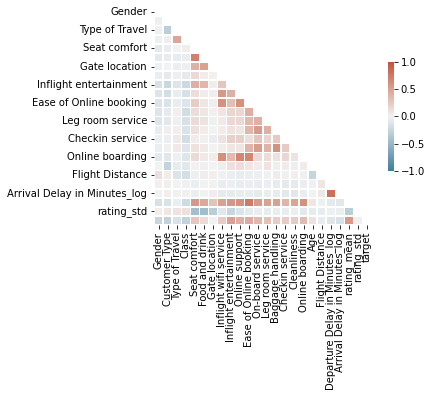

In [32]:
train_set = df_train[selected_features + ['target']].copy()
corr = train_set.corr() # Compute the correlation matrix
mask = np.triu(np.ones_like(corr, dtype=bool))  # Generate a mask for the upper triangle
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, vmin=-1., vmax=1., center=0,
                square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.show()

In [33]:
remove_features = ['Gate location', 'Flight Distance']
# remove_features = ['Gate location']
tmp_features = {k: 0 for k in selected_features}
for f in remove_features:
    if f in selected_features:
        del tmp_features[f]
selected_features = [f for f in tmp_features.keys()]
del tmp_features

print(len(selected_features), selected_features)

21 ['Gender', 'Customer Type', 'Type of Travel', 'Class', 'Seat comfort', 'Food and drink', 'Inflight wifi service', 'Inflight entertainment', 'Online support', 'Ease of Online booking', 'On-board service', 'Leg room service', 'Baggage handling', 'Checkin service', 'Cleanliness', 'Online boarding', 'Age', 'Departure Delay in Minutes_log', 'Arrival Delay in Minutes_log', 'rating_mean', 'rating_std']


In [34]:
df_train = df_train[selected_features + ['target']]
print(df_train.shape)
df_train.head(2)

(3000, 22)


,Gender,Customer Type,Type of Travel,Class,Seat comfort,Food and drink,Inflight wifi service,Inflight entertainment,Online support,Ease of Online booking,On-board service,Leg room service,Baggage handling,Checkin service,Cleanliness,Online boarding,Age,Departure Delay in Minutes_log,Arrival Delay in Minutes_log,rating_mean,rating_std,target
0,0,1,0,1,3,3,4,3,3,4,4,4,3,3,4,4,22,0.000000,0.000000,3.846154,0.688737,0
1,0,0,0,0,2,4,1,4,2,5,4,4,1,0,4,2,37,2.944439,2.944439,3.230769,1.480644,0


In [35]:
def set_seed(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)

In [36]:
cat_dict = {f: 0 for f in selected_cat_features}
for f in selected_cat_features:
    if f not in selected_features:
        del cat_dict[f]

selected_cat_features = [f for f in cat_dict.keys()]
print(selected_cat_features)
print(len(selected_cat_features))

['Gender', 'Customer Type', 'Type of Travel', 'Class', 'Seat comfort', 'Food and drink', 'Inflight wifi service', 'Inflight entertainment', 'Online support', 'Ease of Online booking', 'On-board service', 'Leg room service', 'Baggage handling', 'Checkin service', 'Cleanliness', 'Online boarding']
16


In [37]:
print(selected_num_features)
print(len(selected_num_features))

['Age', 'Flight Distance', 'Departure Delay in Minutes_log', 'Arrival Delay in Minutes_log', 'rating_mean', 'rating_std']
6


In [41]:
print(len(selected_features))

21


In [38]:
SEED = 7777
N_SPLITS = 5
N_ESTIMATORS = 5000

params = {
    'n_estimators': N_ESTIMATORS, 
    'n_jobs': -1, 
    'random_state': SEED,
}

cbt_params = {
    'silent': True,
    'n_estimators': N_ESTIMATORS, 
    'learning_rate': 0.025,
    #'n_jobs': -1, 
    'random_state': SEED,
    #'cat_features': selected_cat_features
}

models = []
set_seed(SEED)

folds = StratifiedKFold(n_splits=N_SPLITS, shuffle=True)
for fold, (train_idx, valid_idx) in enumerate(folds.split(df_train[selected_features], df_train['target'])):
    X_train = df_train.loc[train_idx][selected_features]
    y_train = df_train.loc[train_idx]['target']
    X_valid = df_train.loc[valid_idx][selected_features]
    y_valid = df_train.loc[valid_idx]['target']
   
    #model = RandomForestClassifier(**params)
    model = CatBoostClassifier(**cbt_params)
    model.fit(X_train, y_train)
    models.append(model)
    p_valid = model.predict(X_valid)
    acc = accuracy_score(y_valid, p_valid)
    print(f'#{fold} Accuracy: {acc}')

#0 Accuracy: 0.9383333333333334
#1 Accuracy: 0.9216666666666666
#2 Accuracy: 0.9266666666666666
#3 Accuracy: 0.9166666666666666
#4 Accuracy: 0.9283333333333333


In [ ]:
# grid_param = {
#     'n_estimators': [1000, 2500, 5000],
#     'learning_rate': [0.01, 0.015, 0.02, 0.05],
#     'depth': [8, 12, 16],
#     'min_data_in_leaf': [4, 8, 12, 16],
#     'num_leaves': [4, 8, 12, 16],
#     'l2_leaf_reg': [1, 3, 5, 7]
# }

# cbt_clf = CatBoostClassifier(silent = True)

# grid_search = GridSearchCV(
#     estimator = cbt_clf, 
#     param_grid = grid_param, 
#     cv = 4, 
#     n_jobs = 1, 
#     verbose = 1,
# )

# grid_search.fit(train_set[selected_features], train_set['target'])

In [39]:
df_test = pd.read_csv('test.csv')

for f in delay_features:
    df_test[f'{f}_log'] = np.log1p(df_test[f])

df_test['rating_mean'] = df_test.loc[:, rating_features].mean(axis=1)
df_test['rating_std'] = df_test.loc[:, rating_features].std(axis=1)

for f in selected_features:
    if f in selected_cat_features:
        df_test[f] = le.fit_transform(df_test[f].astype(str))

df_test = df_test[selected_features]
df_test.head()

,Gender,Customer Type,Type of Travel,Class,Seat comfort,Food and drink,Inflight wifi service,Inflight entertainment,Online support,Ease of Online booking,On-board service,Leg room service,Baggage handling,Checkin service,Cleanliness,Online boarding,Age,Departure Delay in Minutes_log,Arrival Delay in Minutes_log,rating_mean,rating_std
0,0,0,1,1,1,1,3,5,4,4,4,5,4,2,4,2,61,3.951244,4.077537,3.615385,1.709701
1,0,1,0,0,1,1,1,1,0,0,2,4,4,3,3,0,27,0.000000,0.000000,2.384615,1.609268
2,0,0,0,0,4,4,4,3,3,4,4,5,4,3,4,2,52,0.000000,0.000000,4.230769,0.725011
3,1,0,0,0,4,4,5,4,4,1,1,2,1,4,1,0,54,0.000000,0.000000,3.230769,1.423250
4,0,0,0,1,4,3,4,4,3,3,2,1,1,4,3,3,41,0.000000,0.000000,3.461538,1.050031


In [40]:
df_test.shape

(2000, 21)

In [42]:
probs = []
for model in models:
    prob = model.predict_proba(df_test[selected_features])
    probs.append(prob)

pred = sum(probs) / len(probs)
pred = np.argmax(pred, axis=1)

df_submit = pd.read_csv('sample_submission.csv')
df_submit['target'] = pred
df_submit.to_csv('/content/gdrive/MyDrive/Dacon/airline/0216_ver1.csv', index=False)